# Assignment 1 - Face Detection Using Integral Image 

In [104]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Integral Image and Local Sum Calculation  

In [105]:
def TransformImage(img_path):
    # Open and convert to grayscale
    img = Image.open(img_path).convert('L') 

    # Convert to NumPy array
    return np.array(img)


In [106]:
def CalculateIntegral(image):
    rows, cols = image.shape
    s = np.zeros_like(image, dtype=np.float64)
    ii = np.zeros_like(image, dtype=np.float64)

    for i in range(rows):
        for j in range(cols):
            s[i, j] = image[i, j] + (s[i, j - 1] if j > 0 else 0)
            ii[i, j] = s[i, j] + (ii[i - 1, j] if i > 0 else 0)

    return ii

In [107]:
image = TransformImage('images/Image 1.jpeg')
print(image)
integral_image = CalculateIntegral(image)
print(integral_image)

[[228 229 229 ... 238 238 238]
 [229 229 229 ... 238 238 238]
 [229 229 229 ... 238 237 237]
 ...
 [224 224 223 ... 237 237 237]
 [223 222 222 ... 237 237 237]
 [221 221 222 ... 236 236 236]]
[[2.28000000e+02 4.57000000e+02 6.86000000e+02 ... 1.73370000e+05
  1.73608000e+05 1.73846000e+05]
 [4.57000000e+02 9.15000000e+02 1.37300000e+03 ... 3.46677000e+05
  3.47153000e+05 3.47629000e+05]
 [6.86000000e+02 1.37300000e+03 2.06000000e+03 ... 5.20321000e+05
  5.21034000e+05 5.21747000e+05]
 ...
 [1.71075000e+05 3.42174000e+05 5.13281000e+05 ... 1.24385942e+08
  1.24563218e+08 1.24740496e+08]
 [1.71298000e+05 3.42619000e+05 5.13948000e+05 ... 1.24472130e+08
  1.24649643e+08 1.24827158e+08]
 [1.71519000e+05 3.43061000e+05 5.14612000e+05 ... 1.24557444e+08
  1.24735193e+08 1.24912944e+08]]


In [108]:
# Quick Check for Last Value
print(integral_image[-1][-1]==np.sum(image))

True


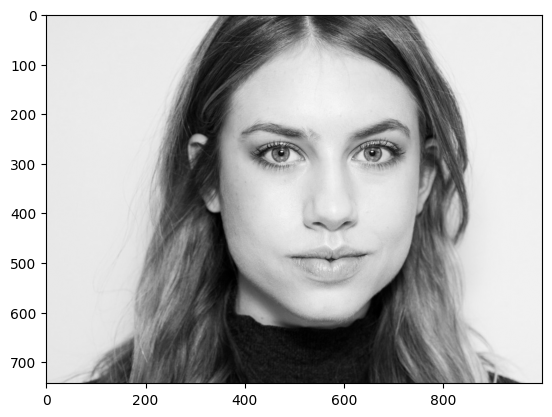

In [109]:
plt.imshow(image, cmap = "gray")

In [110]:
def CalculateLocalSum(integral_image, p0, p1):
    x0, y0 = p0
    x1, y1 = p1

    # Handle borders safely (if x0 or y0 = 0)
    def get(ii, x, y):
        if x < 0 or y < 0:
            return 0
        else:
            return ii[y, x]  # note: row = y, column = x

    return (
        get(integral_image, x1, y1) # whole area
        - get(integral_image, x0 - 1, y1) # left region
        - get(integral_image, x1, y0 - 1) # top region
        + get(integral_image, x0 - 1, y0 - 1)) # top left region that gets subtracted twice

In [111]:
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
integral_image = CalculateIntegral(img)
print(integral_image)
# Test local sum
print(CalculateLocalSum(integral_image, (0, 0), (1, 1)))  # sum of top-left 2x2 → 1+2+4+5 = 12
print(CalculateLocalSum(integral_image, (1, 1), (2, 2)))  # sum of bottom-right 2x2 → 5+6+8+9 = 28
print(CalculateLocalSum(integral_image, (1, 0), (2, 1)))  # sum of top-right 2x2 → 2+3+5+6 = 16

[[ 1.  3.  6.]
 [ 5. 12. 21.]
 [12. 27. 45.]]
12.0
28.0
16.0


## Detect Eye Area  

In [112]:
def DetectEye(integral_img, n):
    m = 0.15 * n  
    h, w = integral_img.shape
    max_score = -np.inf
    max_pos = (0, 0)

    # Define points: (x_offset * n, y_offset * m)
    points = {
        "P1":  (-0.5*n, -0.5*m),
        "P2":  (-0.05*n, 0),
        "P3":  (-0.5*n, 0),
        "P4":  (-0.05*n, 0.5*m),
        "P5":  (0.05*n, -0.5*m),
        "P6":  (0.5*n, 0),
        "P7":  (0.05*n, 0),
        "P8":  (0.5*n, 0.5*m),
        "P9":  (-0.325*n, 0.833*m),
        "P10": (-0.225*n, 2*m),
        "P11": (-0.1*n, 0.833*m),
        "P12": (0.1*n, 2*m),
        "P13": (0.225*n, 0.833*m),
        "P14": (0.325*n, 2*m),
    }

    # Iterate through the image (avoid borders)
    for i in range(int(0.5*m), h - int(2*m)):
        for j in range(int(0.5*n), w - int(0.5*n)):

            # Compute all absolute positions (round to integers)
            abs_pts = {k: (int(j + x), int(i + y)) for k, (x, y) in points.items()}

            # Local sums
            LS1 = CalculateLocalSum(integral_img, abs_pts["P1"], abs_pts["P2"])
            LS2 = CalculateLocalSum(integral_img, abs_pts["P3"], abs_pts["P4"])
            LS3 = CalculateLocalSum(integral_img, abs_pts["P5"], abs_pts["P6"])
            LS4 = CalculateLocalSum(integral_img, abs_pts["P7"], abs_pts["P8"])
            LS5 = CalculateLocalSum(integral_img, abs_pts["P9"], abs_pts["P10"])
            LS6 = CalculateLocalSum(integral_img, abs_pts["P11"], abs_pts["P12"])
            LS7 = CalculateLocalSum(integral_img, abs_pts["P13"], abs_pts["P14"])

            # Combine them (+1, -1)
            score = (LS1 - LS2 + LS3 - LS4 - LS5 + LS6 - LS7)

            # Track maximum score
            if score > max_score:
                max_score = score
                max_pos = (i, j)

    return max_pos

In [113]:
def ExtractDetectedEye(image, max_pos, n):
    image = TransformImage(image)

    output_image = np.zeros_like(image)
    m = int(0.15 * n)  # kernel height
    i_center, j_center = max_pos

    # The kernel is not symmetric vertically:
    #  - It goes roughly 0.5*m above
    #  - and 2*m below the center (from your DetectEye loop bounds)
    top = int(i_center - 0.5 * m)
    bottom = int(i_center + 2 * m)
    left = int(j_center - 0.5 * n)
    right = int(j_center + 0.5 * n)

    # Crop the region of interest (ROI)

    eye_region = image[top:bottom, left:right]
    # Copy this region onto the black output image
    output_image[top:bottom, left:right] = eye_region
    
    # Display the final image
    plt.imshow(output_image, cmap = "gray")
    return output_image

In [114]:
def FinalEyeDetection(path, kernel_size):
    image = TransformImage(path)
    max_pos = DetectEye(CalculateIntegral(image), kernel_size)
    ExtractDetectedEye(path, max_pos, kernel_size)

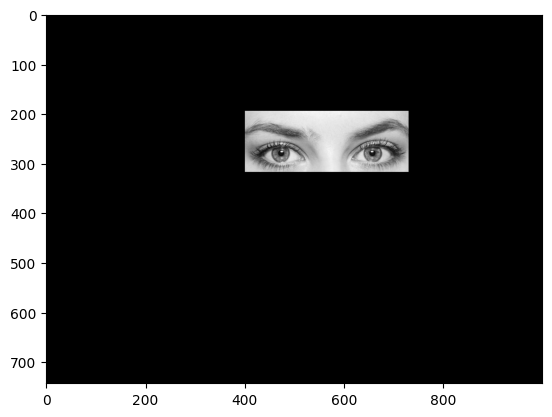

In [115]:
FinalEyeDetection("images/Image 1.jpeg", 330)

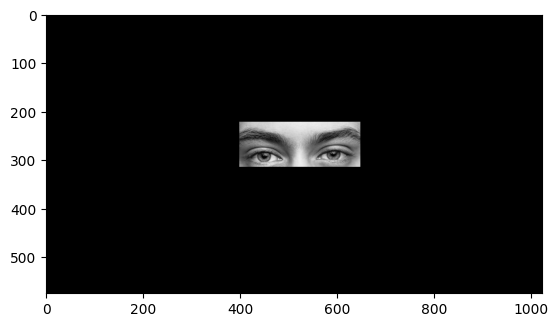

In [116]:
FinalEyeDetection("images/Image 2.jpeg", 250)

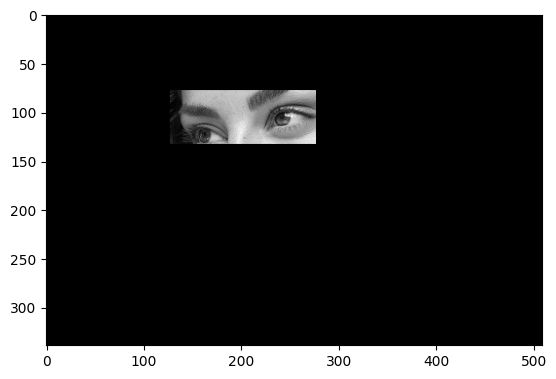

In [117]:
FinalEyeDetection("images/Image 3.jpeg", 150)

In [ ]:
FinalEyeDetection("images/baby.jpg", 150)